In [20]:
import pandas as pd
import numpy as np

Why we choose Random Forest for loan drift project

Fast experimentation — important for simulating model drift and running multiple yearly slices.

Handles categorical & numerical features with minimal preprocessing.

Stable baseline — gives a solid reference before considering complex methods.

Avoids unnecessary complexity — boosting is powerful but overkill for initial drift simulation.

In [21]:
df = pd.read_csv('/content/accepted_2007_to_2018Q4.csv',
    low_memory=False);

In [22]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.dtypes

,0
id,int64
member_id,float64
loan_amnt,float64
funded_amnt,float64
funded_amnt_inv,float64
...,...
settlement_status,object
settlement_date,object
settlement_amount,float64
settlement_percentage,float64


In [24]:
# check target variable
df['loan_status'].value_counts()


,count
loan_status,
Fully Paid,45105
Charged Off,11658
Current,7353
Late (31-120 days),301
In Grace Period,139
Late (16-30 days),47
Default,1


In [25]:
# map statuses to 0/1
target_map = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Current': 0,
    'Late (31-120 days)': 1,
    'In Grace Period': 0,
    'Late (16-30 days)': 1
}

df['target'] = df['loan_status'].map(target_map)

# check distribution
df['target'].value_counts()


,count
target,
0.0,52597
1.0,12006


In [26]:
features = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'issue_d'
]
target = 'target'  # binary target we'll define

# keep only these columns + target placeholder
df_clean = data[features].copy()


In [27]:
df_clean['int_rate'] = df_clean['int_rate'].astype(str).str.rstrip('%').astype(float)


In [28]:
df_clean['int_rate'].head()


,int_rate
0,13.99
1,11.99
2,10.78
3,14.85
4,22.45


In [29]:
import re

def emp_to_int(emp):
    if pd.isnull(emp):
        return 0
    emp = str(emp).strip()
    if emp == '< 1 year':
        return 0
    if emp == '10+ years':
        return 10
    match = re.search(r'(\d+)', emp)
    return int(match.group(1)) if match else 0

df_clean['emp_length'] = df_clean['emp_length'].apply(emp_to_int)


In [30]:
num_cols = ['loan_amnt', 'installment', 'int_rate', 'annual_inc', 'emp_length']
cat_cols = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status']

# numeric → median
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

# categorical → fill with 'Unknown'
df_clean[cat_cols] = df_clean[cat_cols].fillna('Unknown')


In [31]:
df_clean['issue_d'] = pd.to_datetime(df_clean['issue_d'])


In [32]:
df_clean[num_cols].describe()

,loan_amnt,installment,int_rate,annual_inc,emp_length
count,7004.000000,7004.000000,7004.000000,7.004000e+03,7004.000000
mean,15189.384637,444.655493,12.328579,7.860125e+04,5.586950
std,8671.026123,250.348018,4.372144,5.046525e+04,3.889742
min,1000.000000,30.650000,5.320000,9.000000e+03,0.000000
25%,8000.000000,260.297500,9.170000,4.988574e+04,2.000000
50%,14000.000000,389.400000,11.990000,6.900000e+04,5.000000
75%,20000.000000,593.400000,14.850000,9.600000e+04,10.000000
max,35000.000000,1291.480000,28.990000,1.400000e+06,10.000000


In [33]:
df_clean = df_clean.sort_values('issue_d')

Train → older loans

Test → newer loans → simulates future data

In [34]:
# 80% train, 20% test
split_idx = int(len(df_clean) * 0.8)

train_df = df_clean.iloc[:split_idx]
test_df  = df_clean.iloc[split_idx:]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (5603, 11)
Test shape: (1401, 11)


In [37]:
# sort by issue date
df_clean = df_clean.sort_values('issue_d')

# Add the target column to df_clean before splitting
df_clean['target'] = df['target']

# 80% train, 20% test
split_idx = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split_idx]
test_df  = df_clean.iloc[split_idx:]

X_train = train_df[features]
y_train = train_df['target']

X_test = test_df[features]
y_test = test_df['target']

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (5603, 11) (5603,)
Test shape: (1401, 11) (1401,)


In [38]:
df_clean.columns


Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'target'],
      dtype='object')

In [40]:
# map loan_status to 0/1
target_map = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Current': 0,
    'Late (31-120 days)': 1,
    'In Grace Period': 0,
    'Late (16-30 days)': 1
}

df_clean['target'] = data['loan_status'].map(target_map)

# check if it worked
df_clean['target'].value_counts()


,count
target,
0,5777
1,1227


In [44]:
# take a smaller random subset for quick training
X_train_small = X_train.sample(2000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]


In [48]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# numerical and categorical features
num_cols = ['loan_amnt', 'installment', 'int_rate', 'annual_inc', 'emp_length']
cat_cols = ['term', 'grade', 'home_ownership', 'verification_status']  # simplified categorical columns for speed
features = num_cols + cat_cols

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# pipeline for full dataset
pipeline_full = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# train on full dataset
pipeline_full.fit(X_train[features], y_train)

# evaluate on full test set
train_score = pipeline_full.score(X_train[features], y_train)
test_score  = pipeline_full.score(X_test[features], y_test)

print("Train Accuracy (full dataset):", train_score)
print("Test Accuracy (full dataset):", test_score)


Train Accuracy (full dataset): 0.9996430483669463
Test Accuracy (full dataset): 0.7930049964311207


In [49]:
y_test.isna().sum()


np.int64(0)

In [51]:
# keep only rows without NaN target
mask = y_test.notna()
X_test_clean = X_test[mask][features]
y_test_clean = y_test[mask]

# evaluate
test_score = pipeline_full.score(X_test_clean, y_test_clean)
print("Test Accuracy (full dataset):", test_score)


Test Accuracy (full dataset): 0.7930049964311207


In [52]:

y_train.isna().sum()


np.int64(0)

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# numerical and categorical features
num_cols = ['loan_amnt', 'installment', 'int_rate', 'annual_inc', 'emp_length']
cat_cols = ['term', 'grade', 'home_ownership', 'verification_status']  # simplified categorical columns for speed
features = num_cols + cat_cols

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# pipeline for full dataset
pipeline_full = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Clean y_train and y_test for NaN values
mask_train = y_train.notna()
X_train_clean = X_train.loc[mask_train, features]
y_train_clean = y_train.loc[mask_train]

mask_test = y_test.notna()
X_test_clean = X_test.loc[mask_test, features]
y_test_clean = y_test.loc[mask_test]

# train on full dataset with cleaned data
pipeline_full.fit(X_train_clean, y_train_clean)

# evaluate on full test set with cleaned data
train_score = pipeline_full.score(X_train_clean, y_train_clean)
test_score  = pipeline_full.score(X_test_clean, y_test_clean)

print("Train Accuracy (full dataset):", train_score)
print("Test Accuracy (full dataset):", test_score)

Train Accuracy (full dataset): 0.9996430483669463
Test Accuracy (full dataset): 0.7930049964311207


In [46]:
# Keep only rows where target is not NaN
mask_train = y_train.notna()
X_train_clean = X_train.loc[mask_train, features]
y_train_clean = y_train.loc[mask_train]

mask_test = y_test.notna()
X_test_clean = X_test.loc[mask_test, features]
y_test_clean = y_test.loc[mask_test]


Accuracy per year:
year
2015    0.793005
dtype: float64


/tmp/ipython-input-3360511017.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_year = X_test_eval.groupby('year').apply(lambda x: (x['pred'] == x['target']).mean())


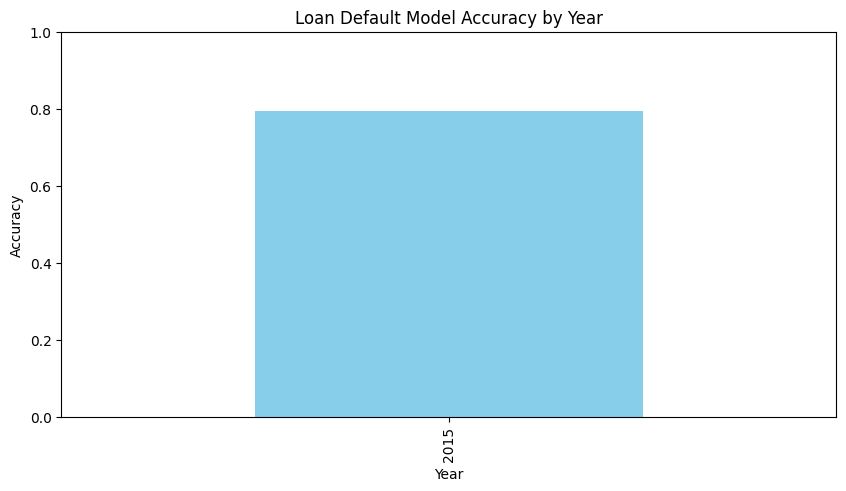

In [55]:
# Keep issue_d in X_test_clean separately for drift analysis
X_test_eval = X_test.loc[mask_test].copy()  # keep all columns
y_test_eval = y_test_clean.copy()

# Predict using only features
y_pred = pipeline_full.predict(X_test_eval[features])

# Add predictions and true target to evaluation DataFrame
X_test_eval['target'] = y_test_eval
X_test_eval['pred'] = y_pred

# Extract year
X_test_eval['issue_d'] = pd.to_datetime(X_test_eval['issue_d'])
X_test_eval['year'] = X_test_eval['issue_d'].dt.year

# Accuracy per year
accuracy_per_year = X_test_eval.groupby('year').apply(lambda x: (x['pred'] == x['target']).mean())

print("Accuracy per year:")
print(accuracy_per_year)

import matplotlib.pyplot as plt

accuracy_per_year.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title("Loan Default Model Accuracy by Year")
plt.ylabel("Accuracy")
plt.xlabel("Year")
plt.ylim(0,1)
plt.show()


In [56]:
# Make a copy for feature drift analysis
df_features = X_test.loc[mask_test].copy()
df_features['target'] = y_test_clean
df_features['issue_d'] = pd.to_datetime(df_features['issue_d'])
df_features['year'] = df_features['issue_d'].dt.year


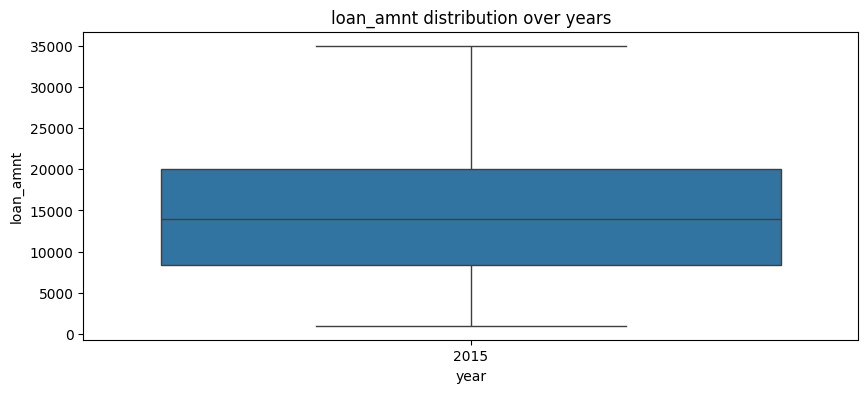

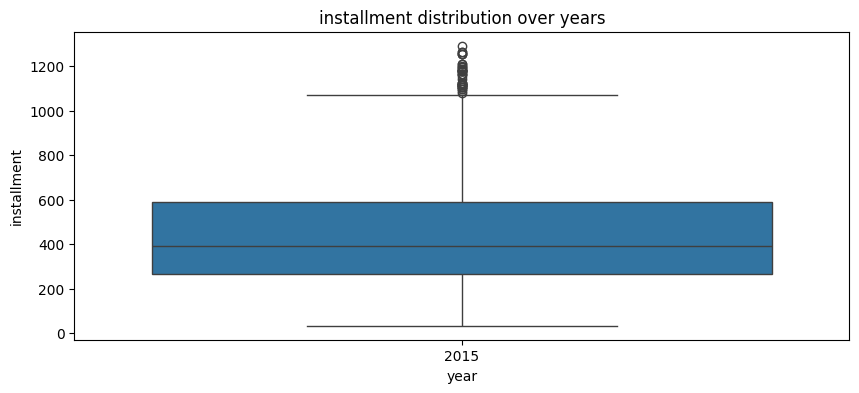

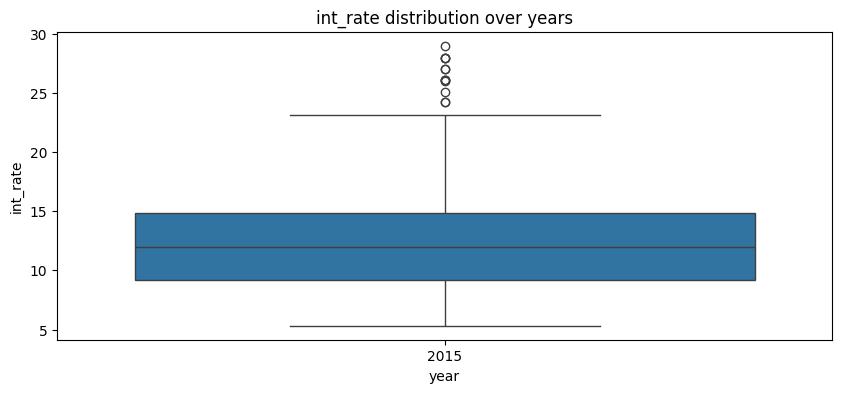

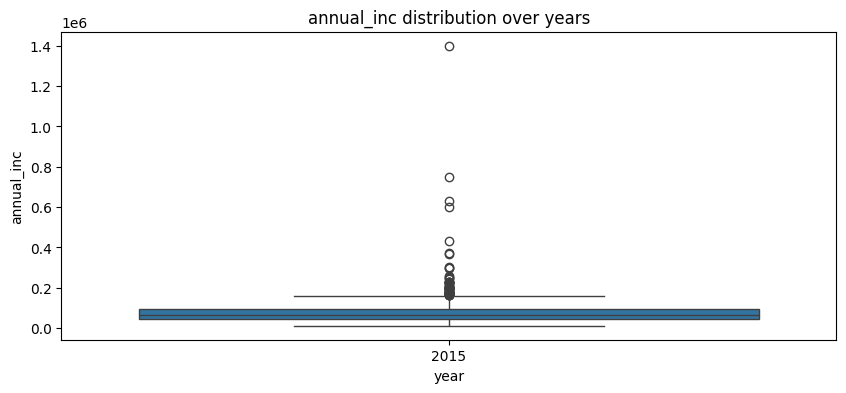

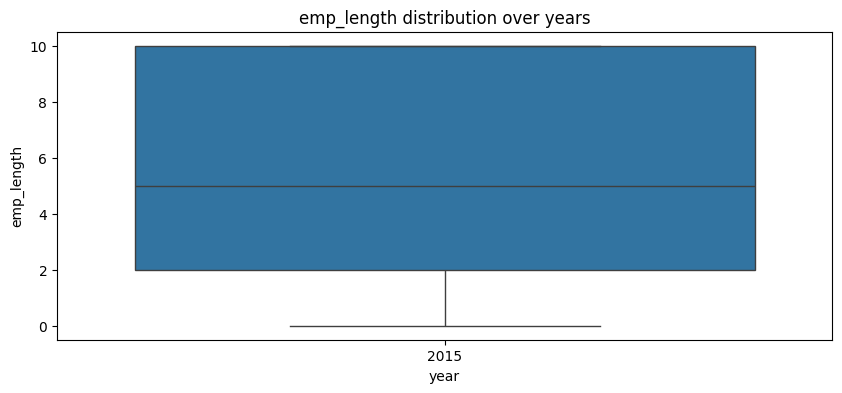

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['loan_amnt', 'installment', 'int_rate', 'annual_inc', 'emp_length']

for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x='year', y=col, data=df_features)
    plt.title(f'{col} distribution over years')
    plt.show()


In [58]:
import joblib

# Save the full pipeline (preprocessing + model)
joblib.dump(pipeline_full, 'loan_rf_pipeline.pkl')


['loan_rf_pipeline.pkl']

In [59]:
def prepare_new_data(new_df):
    new_df = new_df.copy()

    # Ensure all features are present
    for col in features:
        if col not in new_df.columns:
            if col in num_cols:
                new_df[col] = 0
            else:
                new_df[col] = 'Unknown'

    # Keep only the features needed
    new_df = new_df[features]
    return new_df


In [60]:
def predict_new_csv(file_path):
    # Load new data
    new_data = pd.read_csv(file_path)

    # Prepare it
    new_data_prepared = prepare_new_data(new_data)

    # Predict
    preds = pipeline_full.predict(new_data_prepared)
    new_data['predicted_default'] = preds

    # Return predictions
    return new_data


In [61]:
def yearly_accuracy(new_data):
    if 'issue_d' in new_data.columns and 'target' in new_data.columns:
        new_data['issue_d'] = pd.to_datetime(new_data['issue_d'])
        new_data['year'] = new_data['issue_d'].dt.year
        new_data['pred'] = pipeline_full.predict(prepare_new_data(new_data))

        acc_year = new_data.groupby('year').apply(lambda x: (x['pred'] == x['target']).mean())
        print("Yearly accuracy:")
        print(acc_year)
        return acc_year


In [62]:
def predict_new_csv(file_path):
    new_data = pd.read_csv(file_path)
    new_data_prepared = prepare_new_data(new_data)
    preds = pipeline_full.predict(new_data_prepared)
    new_data['predicted_default'] = preds
    return new_data


In [63]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.6 MB/s eta 0:00:00


In [68]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load the saved pipeline
pipeline = joblib.load('loan_default_pipeline.pkl')

features = ['loan_amnt', 'installment', 'int_rate', 'annual_inc', 'emp_length',
            'term', 'grade', 'home_ownership', 'verification_status']
num_cols = ['loan_amnt', 'installment', 'int_rate', 'annual_inc', 'emp_length']
cat_cols = ['term', 'grade', 'home_ownership', 'verification_status']

# Data preparation function
def prepare_new_data(df):
    df = df.copy()
    for col in features:
        if col not in df.columns:
            df[col] = 0 if col in num_cols else 'Unknown'
    return df[features]

st.title("Loan Default Prediction & Drift Analysis")

uploaded_file = st.file_uploader("Upload your CSV file", type=["csv"])
if uploaded_file:
    df = pd.read_csv(uploaded_file)
    df_prepared = prepare_new_data(df)

    # Predict
    df['predicted_default'] = pipeline.predict(df_prepared)

    st.write("Predictions:")
    st.dataframe(df[['predicted_default']].head())

    # Optional: yearly accuracy if target exists
    if 'issue_d' in df.columns and 'target' in df.columns:
        df['issue_d'] = pd.to_datetime(df['issue_d'])
        df['year'] = df['issue_d'].dt.year
        yearly_acc = df.groupby('year').apply(lambda x: (x['predicted_default'] == x['target']).mean())
        st.write("Yearly Accuracy:")
        st.bar_chart(yearly_acc)


Overwriting app.py


In [ ]:
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.140.206:8501

